In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import tensorflow as tf

import sys
sys.path.append('../')

from gpflow.params import Parameterized
from gpflow import autoflow, params_as_tensors
from gpflow.kernels import RBF
from gpflow.likelihoods import Gaussian

from gpflow.training import AdamOptimizer
from natural_gradients_gpflow.natural_gradient_optimizers import NaturalGradientsWithAdamOptimizer

from doubly_stochastic_dgp.dgp import DGP as _DGP
from doubly_stochastic_dgp.dgp import DGP_quad as _DGP_quad

from matplotlib import cm
from scipy.stats import norm


# plotting
import matplotlib.pyplot as plt

In [3]:
from gpflow import settings
class DGP_quad(_DGP_quad):
    def __init__(self, name, *args, **kwargs):
        _DGP_quad.__init__(self, *args, **kwargs)
        self.model_name = name
    @params_as_tensors
    @autoflow((settings.float_type, [None, None]),
             (settings.float_type, [None, None]),
             (settings.float_type, [None, None]))
    def custom_z_log_p_Y(self, X, Y, z):
        s, e = 0, 0
        zs = []
        for layer in self.layers[:-1]:
            e += tf.cast(layer.q_mu.shape[1], dtype=tf.int64)
            zs.append(z[:, s:e])  # this is broken up into each layer, for ease of use
            s = e
        zs.append(tf.zeros([1, 1], dtype=tf.float64))
        Fs, Fmeans, Fvars = self.quadrature_propagate(X, zs)
        var_exp = self.likelihood.variational_expectations(Fmeans[-1], Fvars[-1], Y)  # S, N, D
        return var_exp
    
class DGP(_DGP):
    def __init__(self, name, *args, **kwargs):
        _DGP.__init__(self, *args, **kwargs)
        self.model_name = name
        

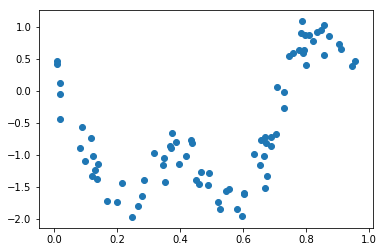

In [25]:
kerns = lambda : [RBF(1, lengthscales=0.5, variance=0.5), RBF(1, lengthscales=0.2)]

def lik():
    l = Gaussian()
    l.variance = 0.005
    return l


N, Ns = 80, 300
M = 50
X = np.random.uniform(0, 1, N).reshape(-1, 1)
X.sort()
# X = np.linspace(0, 1, N).reshape(-1, 1)
Xs = np.linspace(0, 1, Ns).reshape(-1, 1)
Z = np.linspace(-2, 2, M).reshape(-1, 1)

noise_var = 0.05

data_model = DGP('data', X, X, Z, kerns(), lik())
m, v = data_model.predict_f_full_cov(X, 1)
Y = np.random.multivariate_normal(m[0, :, 0], v[0, :, :, 0] + np.eye(N)*noise_var).reshape(-1, 1)

# Y = np.sin(10*X) + np.random.randn(*X.shape) * 0.01
plt.scatter(X, Y)
plt.show()

In [ ]:
models_stochastic = []
models_quad = []

for s in [100, ]:
    models_stochastic.append(DGP('S={}'.format(s), X, Y, Z, kerns(), lik(), 
                                 num_samples=s))

for q in [100, ]:
    models_stochastic.append(DGP_quad('Q={}'.format(q), X, Y, Z, kerns(), lik(), 
                                      H=q))

models = models_stochastic + models_quad


In [ ]:
for model in models:
    p = [[model.layers[-1].q_mu, model.layers[-1].q_sqrt]]
    NaturalGradientsWithAdamOptimizer(0.01).minimize(model, maxiter=1000, nat_grads_params_list=p)
    

In [ ]:
L = len(models[0].layers)
fig, axs = plt.subplots(1, L, figsize=(L*10, 10))

for model in models:
    
    lFs, lms, lvs = model.predict_all_layers_full_cov(Xs, 5)
    
    
    for Fs, ms, vs, ax in zip(lFs, lms, lvs, axs):
        ms = ms[:, :, 0]
        vs = vs[:, :, 0]
        m = np.average(ms, 0)
        v_diag = np.array([np.diag(_v) for _v in vs])
        v = np.average((m[None, :] - ms)**2 + v_diag, 0)
        ax.plot(Xs.flatten(), m, label=model.model_name)
        l, u = [m + s * v**0.5 for s in [2, -2]]
        ax.fill_between(Xs.flatten(), l, u, alpha=0.1)
        ax.plot(Xs.flatten(), Fs[:, :, 0].T)

plt.scatter(X, Y)
    
plt.legend()
plt.show()

In [14]:
plt.show()

In [15]:
for model in models:
    print(model.model_name)
    for _ in range(3):
        print(model.compute_log_likelihood())

S=100
83.0066320039
82.9181446039
82.9977871059
Q=100
-1392.05982746
-1392.05982746
-1392.05982746


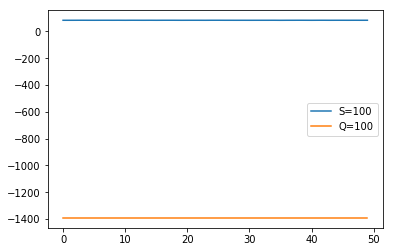

In [16]:
for model in models:
    L = [model.compute_log_likelihood() for _ in range(50)]
    plt.plot(L, label=model.model_name)

plt.legend()
plt.show()

In [17]:
model = models[-1]
zs = np.linspace(-5, 5, 1000).reshape(-1, 1)

In [18]:
r = model.custom_z_log_p_Y(X, Y, zs)

In [19]:
print(r.shape)
print(model)

(1000, 80, 1)
                                             class prior   transform  \
DGP_quad/layers/item0/q_mu               Parameter  None      (none)   
DGP_quad/layers/item0/q_sqrt             Parameter  None  LoTri->vec   
DGP_quad/layers/item0/kern/lengthscales  Parameter  None         +ve   
DGP_quad/layers/item0/kern/variance      Parameter  None         +ve   
DGP_quad/layers/item0/feature/Z          Parameter  None      (none)   
DGP_quad/layers/item0/mean_function/A    Parameter  None      (none)   
DGP_quad/layers/item0/mean_function/b    Parameter  None      (none)   
DGP_quad/layers/item1/q_mu               Parameter  None      (none)   
DGP_quad/layers/item1/q_sqrt             Parameter  None  LoTri->vec   
DGP_quad/layers/item1/kern/lengthscales  Parameter  None         +ve   
DGP_quad/layers/item1/kern/variance      Parameter  None         +ve   
DGP_quad/layers/item1/feature/Z          Parameter  None      (none)   

                                         trainabl

/vol/bitbucket/hrs13/GPflow/gpflow/misc.py:30: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  df = df.reindex_axis(keys, axis=1)


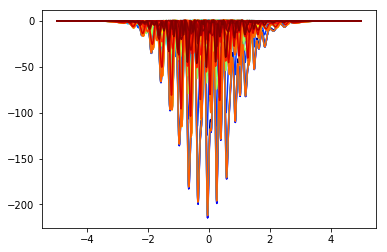

In [20]:
fs = norm.pdf(zs.flatten())

for i, rr in enumerate(r[:, :, 0].T):
    
    plt.plot(zs, rr * fs, c=cm.jet(np.linspace(0, 1, N)[i]))
    
#     plt.plot(zs, rr, c=cm.jet(np.linspace(0, 1, N)[i]))
#     plt.show()
plt.show()

In [ ]:
# for layers in zip(*[model.layers for model in models]):
#     q_mu = np.random.randn(M, 1)
#     q_sqrt = np.random.randn(M, M, 1)
    
#     for layer in layers:
#         layer.q_mu = q_mu
#         layer.q_sqrt = q_sqrt

